Developing an AI application
Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, you might want to include an image classifier in a smartphone app. To do this, you'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications.

In this project, you'll train an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice, you'd train this classifier, then export it for use in your application. We'll be using this dataset of 102 flower categories, you can see a few examples below.


The project is broken down into multiple steps:

Load and preprocess the image dataset
Train the image classifier on your dataset
Use the trained classifier to predict image content
We'll lead you through each part which you'll implement in Python.

When you've completed this project, you'll have an application that can be trained on any set of labeled images. Here your network will be learning about flowers and end up as a command line application. But, what you do with your new skills depends on your imagination and effort in building a dataset. For example, imagine an app where you take a picture of a car, it tells you what the make and model is, then looks up information about it. Go build your own dataset and make something new.

First up is importing the packages you'll need. It's good practice to keep all the imports at the beginning of your code. As you work through this notebook and find you need to import a package, make sure to add the import up here.

Please make sure if you are running this notebook in the workspace that you have chosen GPU rather than CPU mode.

In [1]:
# Imports here
import torch
from torch import nn
from torch import optim
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from PIL import Image
from torchvision import datasets, transforms, models
import numpy as np
from torch.utils.data import DataLoader 
from torch.autograd import Variable

import os
import json
import time
from collections import OrderedDict
from torch.optim import lr_scheduler
import seaborn as sb

Load the data
Here you'll use torchvision to load the data (documentation). The data should be included alongside this notebook, otherwise you can download it here. The dataset is split into three parts, training, validation, and testing. For the training, you'll want to apply transformations such as random scaling, cropping, and flipping. This will help the network generalize leading to better performance. You'll also need to make sure the input data is resized to 224x224 pixels as required by the pre-trained networks.
The validation and testing sets are used to measure the model's performance on data it hasn't seen yet. For this you don't want any scaling or rotation transformations, but you'll need to resize then crop the images to the appropriate size.
The pre-trained networks you'll use were trained on the ImageNet dataset where each color channel was normalized separately. For all three sets you'll need to normalize the means and standard deviations of the images to what the network expects. For the means, it's [0.485, 0.456, 0.406] and for the standard deviations [0.229, 0.224, 0.225], calculated from the ImageNet images. These values will shift each color channel to be centered at 0 and range from -1 to 1.

!wget 'https://s3.amazonaws.com/content.udacity-data.com/nd089/flower_data.tar.gz'
!unlink flowers
!mkdir flowers && tar -xzf flower_data.tar.gz -C flowers

In [2]:
data_dir = 'flowers'
train_dir = data_dir + '/train'
valid_dir = data_dir + '/valid'
test_dir = data_dir + '/test'

In [3]:
# TODO: Define your transforms for the training, validation, and testing sets
data_transforms = {
    'training' : transforms.Compose([transforms.RandomResizedCrop(224),
                                     transforms.RandomHorizontalFlip(),transforms.RandomRotation(30),
                                     transforms.ToTensor(),
                                     transforms.Normalize([0.485, 0.456, 0.406],
                                                          [0.229, 0.224, 0.225])]),

    'validation' : transforms.Compose([transforms.CenterCrop(224),
                                       transforms.Resize(256),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])]),

    'testing' : transforms.Compose([transforms.Resize(256),
                                    transforms.CenterCrop(224),
                                    transforms.ToTensor(),
                                    transforms.Normalize([0.485, 0.456, 0.406],
                                                         [0.229, 0.224, 0.225])])
}

# TODO: Load the datasets with ImageFolder
image_datasets = {
    'training' : datasets.ImageFolder(train_dir,data_transforms['training']),
    'testing' : datasets.ImageFolder(test_dir, data_transforms['testing']),
    'validation' : datasets.ImageFolder(valid_dir,data_transforms['validation'])
}

# TODO: Using the image datasets and the trainforms, define the dataloaders
dataloaders = {
    'training' : DataLoader(image_datasets['training'],batch_size=64,shuffle=True),
    'testing'  : DataLoader(image_datasets['testing'],batch_size=32),
    'validation': DataLoader(image_datasets['validation'],batch_size=32)
}
# print the data to make sure it looks right and no errors
print("data_transforms {}".format(data_transforms))
print("image_datasets {}".format(image_datasets))
print("dataloaders {}".format(dataloaders))
#TODO: Know your data
dataset_sizes = {x: len(image_datasets[x]) for x in ['training', 'validation', 'testing']}
class_names = image_datasets['training'].classes

print ("Dataset Size: "+ str(dataset_sizes) + "\n")
n_class = len(class_names)
print ("Number of classes: "+ str(n_class) + "\n")
print ("Classes: "+ str(class_names) + "\n")
print (len(dataloaders))

class_to_idx = image_datasets['training'].class_to_idx

data_transforms {'training': Compose(
    RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear, antialias=warn)
    RandomHorizontalFlip(p=0.5)
    RandomRotation(degrees=[-30.0, 30.0], interpolation=nearest, expand=False, fill=0)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
), 'validation': Compose(
    CenterCrop(size=(224, 224))
    Resize(size=256, interpolation=bilinear, max_size=None, antialias=warn)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
), 'testing': Compose(
    Resize(size=256, interpolation=bilinear, max_size=None, antialias=warn)
    CenterCrop(size=(224, 224))
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)}
image_datasets {'training': Dataset ImageFolder
    Number of datapoints: 6552
    Root location: flowers/train
    StandardTransform
Transform: Compose(
               RandomResizedCrop(size=(224, 224),

224


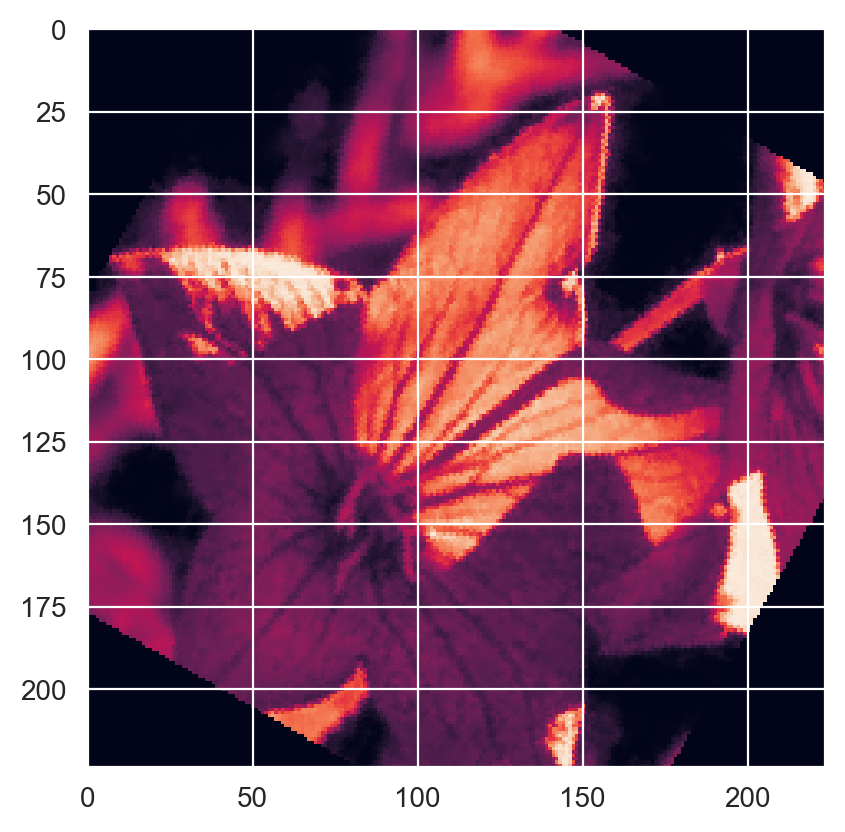

In [4]:
images, labels = next(iter(dataloaders["training"]))
print(len(images[0,2]))
plt.imshow(images[0,0])

Label mapping
You'll also need to load in a mapping from category label to category name. You can find this in the file cat_to_name.json. It's a JSON object which you can read in with the json module. This will give you a dictionary mapping the integer encoded categories to the actual names of the flowers.

In [5]:
with open('cat_to_name.json', 'r') as f:
    cat_to_name = json.load(f)
   
print(cat_to_name)
print("\n Number of flower types:", len(cat_to_name))

{'21': 'fire lily', '3': 'canterbury bells', '45': 'bolero deep blue', '1': 'pink primrose', '34': 'mexican aster', '27': 'prince of wales feathers', '7': 'moon orchid', '16': 'globe-flower', '25': 'grape hyacinth', '26': 'corn poppy', '79': 'toad lily', '39': 'siam tulip', '24': 'red ginger', '67': 'spring crocus', '35': 'alpine sea holly', '32': 'garden phlox', '10': 'globe thistle', '6': 'tiger lily', '93': 'ball moss', '33': 'love in the mist', '9': 'monkshood', '102': 'blackberry lily', '14': 'spear thistle', '19': 'balloon flower', '100': 'blanket flower', '13': 'king protea', '49': 'oxeye daisy', '15': 'yellow iris', '61': 'cautleya spicata', '31': 'carnation', '64': 'silverbush', '68': 'bearded iris', '63': 'black-eyed susan', '69': 'windflower', '62': 'japanese anemone', '20': 'giant white arum lily', '38': 'great masterwort', '4': 'sweet pea', '86': 'tree mallow', '101': 'trumpet creeper', '42': 'daffodil', '22': 'pincushion flower', '2': 'hard-leaved pocket orchid', '54': 's

In [6]:
# TODO: Build and train your network
model = models.vgg16(pretrained=True)

for param in model.parameters():
    param.requires_grad = False

C:\Users\PANDA\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\PANDA\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [7]:
input_size = 25088
hidden_sizes = [5024, 1024, 256]
output_size = 102
dropout = 0.4

classifier = nn.Sequential(OrderedDict([
                      ('fc1', nn.Linear(input_size, hidden_sizes[0])),
                      ('relu1', nn.ReLU()),
                      ('dropout1', nn.Dropout(dropout)),
                      ('fc2', nn.Linear(hidden_sizes[0], hidden_sizes[1])),
                      ('relu2', nn.ReLU()),
                      ('dropout1', nn.Dropout(dropout)),
                      ('fc3', nn.Linear(hidden_sizes[1], hidden_sizes[2])),
                      ('relu3', nn.ReLU()),
                      ('dropout1', nn.Dropout(dropout)),
                      ('output', nn.Linear(hidden_sizes[2], output_size)),
                      ('softmax', nn.LogSoftmax(dim=1))
]))
model.classifier = classifier
# Check
model.classifier

Sequential(
  (fc1): Linear(in_features=25088, out_features=5024, bias=True)
  (relu1): ReLU()
  (dropout1): Dropout(p=0.4, inplace=False)
  (fc2): Linear(in_features=5024, out_features=1024, bias=True)
  (relu2): ReLU()
  (fc3): Linear(in_features=1024, out_features=256, bias=True)
  (relu3): ReLU()
  (output): Linear(in_features=256, out_features=102, bias=True)
  (softmax): LogSoftmax(dim=1)
)

In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr = 0.001)
# change model to CPU or GPU from device
model.to(device)
device

device(type='cpu')

In [9]:
epochs = 3

train_losses, valid_losses = [], []
for e in range(epochs):
    running_loss = 0
    for images, labels in dataloaders['training']:
        # Move image and label tensors to device
        images, labels = images.to(device), labels.to(device)
        
        # Zero out gradients
        optimizer.zero_grad()
        
        # Run training
        log_ps = model(images)
        loss = criterion(log_ps, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
    else:
        valid_loss = 0
        accuracy = 0
        
        # Place model into eval
        model.eval()
        
        # Turn off gradients
        with torch.no_grad():
            for images, labels in dataloaders['validation']:
                # Move image and label tensors to device
                images, labels = images.to(device), labels.to(device)
                
                log_ps = model(images)
                loss = criterion(log_ps, labels)
                valid_loss += loss.item()
                
                # Calculate accuracy
                ps = torch.exp(log_ps)
                top_p, top_class = ps.topk(1, dim=1)
                equals = top_class == labels.view(*top_class.shape)
                accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
        
            train_losses.append(running_loss/len(dataloaders['training']))
            valid_losses.append(valid_loss/len(dataloaders['validation']))
        model.train()
        
        print("Epoch: {}/{}.. ".format(e+1, epochs),
              "Training Loss: {:.3f}.. ".format(running_loss/len(dataloaders['training'])),
              "Valid Loss: {:.3f}.. ".format(valid_loss/len(dataloaders['validation'])),
              "Valid Accuracy: {:.3f}".format(accuracy/len(dataloaders['validation'])))
        

Epoch: 1/3..  Training Loss: 3.620..  Valid Loss: 2.814..  Valid Accuracy: 0.279
Epoch: 2/3..  Training Loss: 2.184..  Valid Loss: 2.215..  Valid Accuracy: 0.406
Epoch: 3/3..  Training Loss: 1.729..  Valid Loss: 2.117..  Valid Accuracy: 0.456


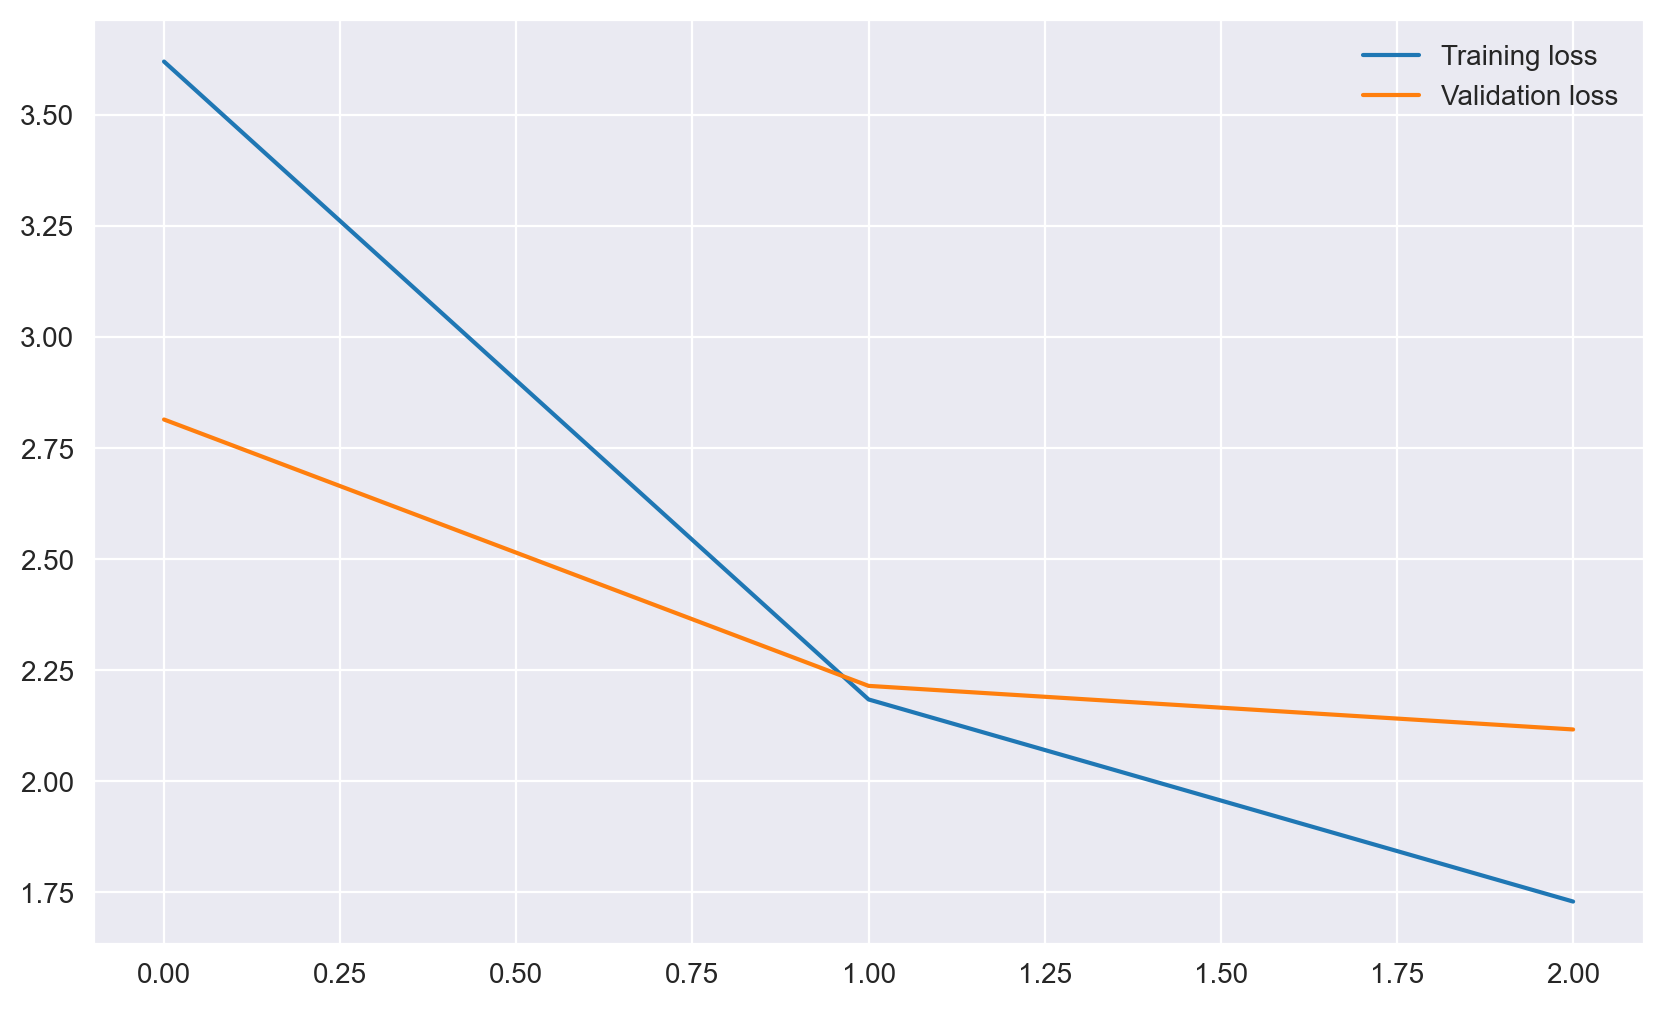

In [10]:
# Plot the losses as a check for overfitting
plt.figure(figsize=[10, 6])
plt.plot(train_losses, label='Training loss')
plt.plot(valid_losses, label='Validation loss')
plt.legend(frameon=False)

Testing your network
It's good practice to test your trained network on test data, images the network has never seen either in training or validation. This will give you a good estimate for the model's performance on completely new images. Run the test images through the network and measure the accuracy, the same way you did validation. You should be able to reach around 70% accuracy on the test set if the model has been trained well.


In [11]:
# TODO: Do validation on the test set
test_loss = 0
accuracy = 0
model.eval()

with torch.no_grad():
    for images, labels in dataloaders['testing']:
        # Move image and label tensors to device
        images, labels = images.to(device), labels.to(device)
                
        log_ps = model(images)
        loss = criterion(log_ps, labels)
        test_loss += loss.item()
                
        # Calculate accuracy
        ps = torch.exp(log_ps)
        top_p, top_class = ps.topk(1, dim=1)
        equals = top_class == labels.view(*top_class.shape)
        accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
      
    model.train()
          
print("Test Loss: {}\n".format(test_loss/len(dataloaders['testing'])),
     "Test Accuracy: {}".format(accuracy/len(dataloaders['testing'])))

Test Loss: 1.3052826260144894
 Test Accuracy: 0.6468876508566049


Save the checkpoint
Now that your network is trained, save the model, so you can load it later for making predictions. You probably want to save other things such as the mapping of classes to indices which you get from one of the image datasets: image_datasets['train'].class_to_idx. You can attach this to the model as an attribute which makes inference easier later on.

model.class_to_idx = image_datasets['train'].class_to_idx

Remember that you'll want to completely rebuild the model later, so you can use it for inference. Make sure to include any information you need in the checkpoint. If you want to load the model and keep training, you'll want to save the number of epochs as well as the optimizer state, optimizer.state_dict. You'll likely want to use this trained model in the next part of the project, so best to save it now.

In [12]:
# TODO: Save the checkpoint 
model.class_to_idx = image_datasets['training'].class_to_idx

checkpoint = {'input_size': 25088,
              'output_size': 102,
              'arch': 'vgg16',
              'learning_rate': 0.001,
              'batch_size': 64,
              'classifier' : classifier,
              'epochs': epochs,
              'optimizer': optimizer.state_dict(),
              'state_dict': model.state_dict(),
              'class_to_idx': model.class_to_idx
              }

torch.save(checkpoint, 'checkpoint.pth');

In [13]:
torch.load('checkpoint.pth')

{'input_size': 25088,
 'output_size': 102,
 'arch': 'vgg16',
 'learning_rate': 0.001,
 'batch_size': 64,
 'classifier': Sequential(
   (fc1): Linear(in_features=25088, out_features=5024, bias=True)
   (relu1): ReLU()
   (dropout1): Dropout(p=0.4, inplace=False)
   (fc2): Linear(in_features=5024, out_features=1024, bias=True)
   (relu2): ReLU()
   (fc3): Linear(in_features=1024, out_features=256, bias=True)
   (relu3): ReLU()
   (output): Linear(in_features=256, out_features=102, bias=True)
   (softmax): LogSoftmax(dim=1)
 ),
 'epochs': 3,
 'optimizer': {'state': {0: {'step': tensor(309.),
    'exp_avg': tensor([[ 0.0000e+00,  8.7250e-20,  8.6603e-20,  ..., -3.8584e-19,
              6.3395e-19,  2.4339e-19],
            [ 1.0080e-21,  0.0000e+00,  0.0000e+00,  ..., -1.0571e-20,
             -3.6546e-20,  0.0000e+00],
            [-2.3500e-08,  3.8869e-06, -3.1651e-07,  ..., -1.6914e-06,
              1.5651e-06,  1.0326e-07],
            ...,
            [ 8.0256e-14,  1.4755e-19,  1.0

Loading the checkpoint
At this point it's good to write a function that can load a checkpoint and rebuild the model. That way you can come back to this project and keep working on it without having to retrain the network.

In [14]:
import torchvision
# TODO: Write a function that loads a checkpoint and rebuilds the model

# noinspection PyShadowingNames
def load_checkpoint(filename='checkpoint.pth'):
    checkpoint= torch.load(filename)
    learning_rate : checkpoint['learning_rate']
    model = getattr(torchvision.models, checkpoint['arch'])(pretrained=True)
    model.class_to_idx = checkpoint['class_to_idx']
    model.classifier = checkpoint['classifier']
    model.epochs = checkpoint['epochs']
    model.load_state_dict(checkpoint['state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer'])
        
    return model, optimizer

In [15]:
nn_filename = 'checkpoint.pth'
model, optimizer = load_checkpoint('checkpoint.pth')
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

Inference for classification
Now you'll write a function to use a trained network for inference. That is, you'll pass an image into the network and predict the class of the flower in the image. Write a function called predict that takes an image and a model, then returns the top 
 most likely classes along with the probabilities. It should look like
 probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
First you'll need to handle processing the input image such that it can be used in your network.

Image Preprocessing
You'll want to use PIL to load the image (documentation). It's best to write a function that preprocesses the image, so it can be used as input for the model. This function should process the images in the same manner used for training.

First, resize the images where the shortest side is 256 pixels, keeping the aspect ratio. This can be done with the thumbnail or resize methods. Then you'll need to crop out the center 224x224 portion of the image.

Color channels of images are typically encoded as integers 0-255, but the model expected floats 0-1. You'll need to convert the values. It's easiest with a Numpy array, which you can get from a PIL image like so np_image = np.array(pil_image).

As before, the network expects the images to be normalized in a specific way. For the means, it's [0.485, 0.456, 0.406] and for the standard deviations [0.229, 0.224, 0.225]. You'll want to subtract the means from each color channel, then divide by the standard deviation.

And finally, PyTorch expects the color channel to be the first dimension, but it's the third dimension in the PIL image and Numpy array. You can reorder dimensions using ndarray.transpose. The color channel needs to be first and retain the order of the other two dimensions.


In [16]:
# noinspection PyShadowingNames
def process_image(image):
    """ Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns a Numpy array
    """
    
    # TODO: Process a PIL image for use in a PyTorch mod
    img = Image.open(image)
    img = img.resize((256,256))
    value = 0.5*(256-224)
    img = img.crop((value,value,256-value,256-value))
    img = np.array(img)/255

    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = (img - mean) / std

    return img.transpose(2,0,1)

To check your work, the function below converts a PyTorch tensor and displays it in the notebook. If your process_image function works, running the output through this function should return the original image (except for the cropped out portions).

In [17]:
# noinspection PyShadowingNames,PyUnusedLocal
def imshow(image, ax=None, title=None):
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch's tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

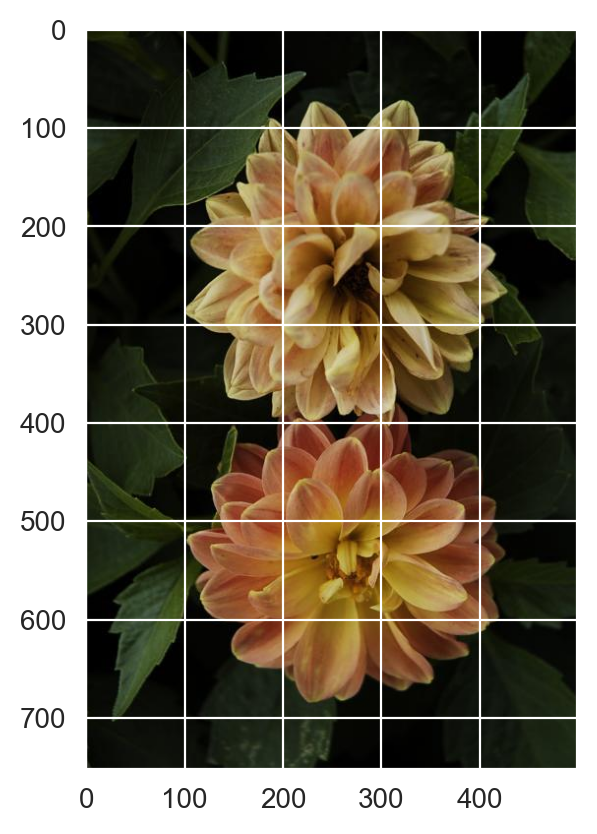

In [18]:
import os
import random
img = random.choice(os.listdir('./flowers/test/60/'))
img_path = './flowers/test/60/' + img

with Image.open(img_path) as image:
    plt.imshow(image)

Class Prediction
Once you can get images in the correct format, it's time to write a function for making predictions with your model. A common practice is to predict the top 5 or so (usually called top-
) most probable classes. You'll want to calculate the class probabilities then find the 
 largest values.

To get the top 
 largest values in a tensor use x.topk(k). This method returns both the highest k probabilities and the indices of those probabilities corresponding to the classes. You need to convert from these indices to the actual class labels using class_to_idx which hopefully you added to the model or from an ImageFolder you used to load the data (see here). Make sure to invert the dictionary, so you get a mapping from index to class as well.

Again, this method should take a path to an image and a model checkpoint, then return the probabilities and classes.

probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']

In [19]:
# noinspection PyShadowingNames
def predict(image_path, model, topk=5):

    """ Predict the class (or classes) of an image using a trained deep learning model.
    """
    
    # TODO: Implement the code to predict the class from an image file
    cuda = torch.cuda.is_available()
    if cuda:

        model.cuda()
        print("Number of the GPUs:", torch.cuda.device_count())
        print("Name of the Device:", torch.cuda.get_device_name(torch.cuda.device_count()-1))
    else:
        model.cpu()
        print("Choose CPU")
    
    model.eval()

    image = process_image(image_path)

    image = torch.from_numpy(np.array([image])).float()
    
    image = Variable(image)
    if cuda:
        image = image.cuda()
        
    output = model.forward(image)
    
    probabilities = torch.exp(output).data

    probs = torch.topk(probabilities, topk)[0].tolist()[0] 
    index = torch.topk(probabilities, topk)[1].tolist()[0] 
    
    ind = []
    for i in range(len(model.class_to_idx.items())):
        ind.append(list(model.class_to_idx.items())[i][0])

    cls= []
    for i in range(5):
        cls.append(ind[index[i]])

    return probs, cls
prob, classes = predict(img_path, model)
print(prob)
print(classes)

Choose CPU
[0.9539830088615417, 0.045288700610399246, 0.00036294962046667933, 0.0002403844555374235, 6.204008241184056e-05]
['60', '73', '24', '41', '81']


In [20]:
img = random.choice(os.listdir('./flowers/test/60/'))
img_path = './flowers/test/60/' + img

prob, classes = predict(img_path, model)
print(prob)
print(classes)   
print([cat_to_name[x] for x in classes])

Choose CPU
[0.9993138313293457, 0.0005517341196537018, 4.86376193293836e-05, 4.842273483518511e-05, 1.621622868697159e-05]
['60', '50', '41', '73', '5']
['pink-yellow dahlia', 'common dandelion', 'barbeton daisy', 'water lily', 'english marigold']


Sanity Checking
Now that you can use a trained model for predictions, check to make sure it makes sense. Even if the testing accuracy is high, it's always good to check that there aren't obvious bugs. Use matplotlib to plot the probabilities for the top 5 classes as a bar graph, along with the input image. It should look like this:


You can convert from the class integer encoding to actual flower names with the cat_to_name.json file (should have been loaded earlier in the notebook). To show a PyTorch tensor as an image, use the imshow function defined above.

Choose CPU


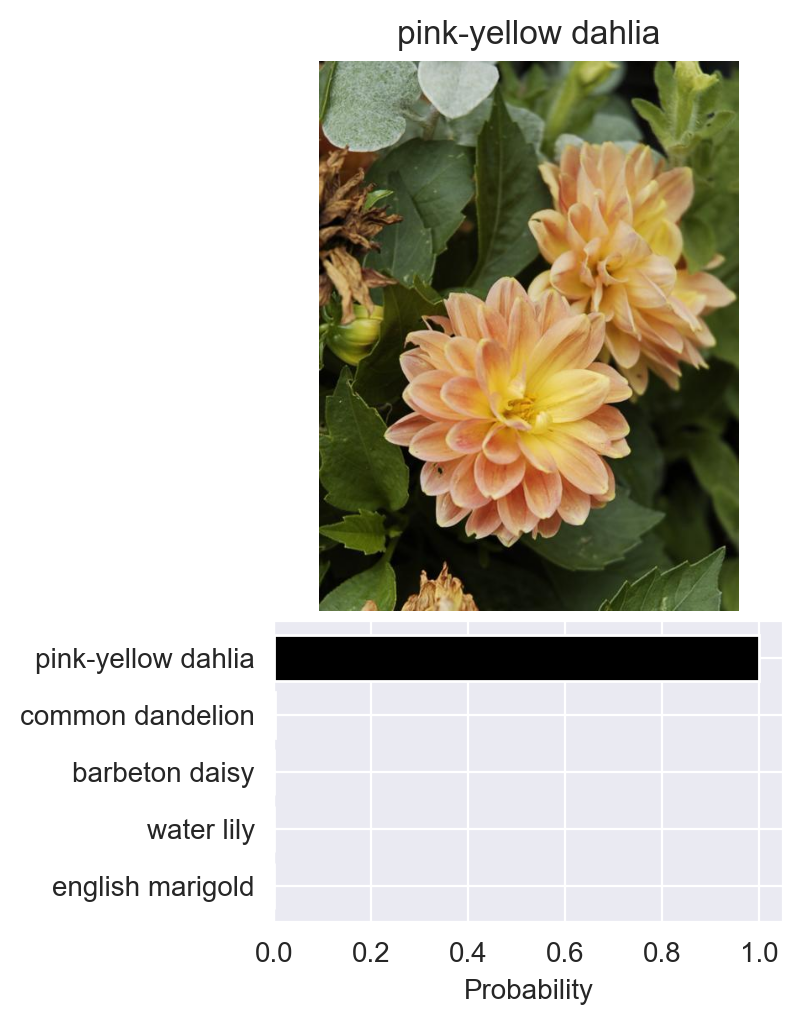

In [21]:
# TODO: Display an image along with the top 5 classes
prob, classes = predict(img_path, model)
max_index = np.argmax(prob)
max_probability = prob[max_index]
cls= classes[max_index]
fig = plt.figure(figsize=(6,6))
ax1 = plt.subplot2grid((15,9), (0,0), colspan=9, rowspan=9)
ax2 = plt.subplot2grid((15,9), (9,2), colspan=5, rowspan=5)

# noinspection PyRedeclaration
image = Image.open(img_path)
ax1.axis('off')
ax1.set_title(cat_to_name[cls])
ax1.imshow(image)

cls = []
for cl in classes:
    cls.append(cat_to_name[cl])
    
y_pos = np.arange(5)
ax2.set_yticks(y_pos)
ax2.set_yticklabels(cls)
ax2.set_xlabel('Probability')
ax2.invert_yaxis()
ax2.barh(y_pos, prob, xerr=0, align='center', color='black')

plt.show()

Reminder for Workspace users
If your network becomes very large when saved as a checkpoint, there might be issues with saving backups in your workspace. You should reduce the size of your hidden layers and train again.

We strongly encourage you to delete these large interim files and directories before navigating to another page or closing the browser tab.

In [22]:
# TODO remove .pth files or move it to a temporary `~/opt` directory in this Workspace